In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.tree import DecisionTreeRegressor

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Read in data

In [2]:
# Read in
df9 = pd.read_csv('../data/df9.csv')

In [3]:
df9

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,-1.912877,-0.509738,1.935923,-2.119992,0.474137,3.647543,A2,B2,C33,D3,-23.858957
1,-0.341252,0.341502,2.268666,-0.948835,-0.492523,4.159113,A1,B4,C32,D2,4.795576
2,0.658157,-0.347933,3.104409,0.236928,0.359240,6.498557,A1,B4,C4,D2,16.359090
3,2.288540,-1.028834,3.554489,-0.215137,-0.436760,7.154874,A2,B1,C11,D3,-24.550723
4,0.618358,-1.526877,3.857197,-0.343902,0.098206,7.857794,A2,B2,C12,D3,-23.033020
...,...,...,...,...,...,...,...,...,...,...,...
995,-0.377935,-0.810448,3.658649,0.614948,-1.292935,7.227878,A1,B1,C13,D3,14.729703
996,0.968435,1.273159,3.449217,-0.073787,1.088958,6.701653,A1,B4,C42,D2,5.337900
997,0.919181,-1.518937,3.427333,1.152154,0.039267,6.797440,A2,B1,C22,D3,-8.781643
998,0.248702,-0.184816,2.923806,1.188720,-0.361918,6.040283,A2,B5,C11,D2,-15.494192


# Random Forest

Random Forests use bagging (bootstrap aggregating) to help reduce the variance of tree models and prevent overfitting.

- Build `n` independent trees, where in tree we do the following:
    - Create a bootstrap sample the size of the original data
    - Randomly sample `n_features` predictors
- "Predict" the mean of these `n` trees

See https://en.wikipedia.org/wiki/Bootstrap_aggregating for some details and links (e.g. to the original bagging research paper).

In [4]:
# Create class
class DereksRandomForest(object):
    def __init__(self, n_trees, n_features, X, y):
        """
        n_trees: How many independent trees to build
        n_features: How many features to use for each tree
        X: The matrix of rows and predictors
        y: The targets
        """
        self.n_trees = n_trees
        self.n_features = n_features
        self.X = X
        self.y = y
        self.trees = []
        
    def fit(self, **kwargs):
        """Create n_trees trees, each with it's own bootstraped and feature-subsetted data set
        kwargs: Kwargs passed to DecisionTreeRegressor
        """
        for i in range(self.n_trees):
            # Boostrap sample rows
            index_bootstrap_rows = np.random.choice(self.X.shape[0], self.X.shape[0])
            # Subset predictors
            # -> For ease of implementation, instead of subsetting to the chosen features we zero out the rest of them so that we'll never split on them
            index_predictors = np.random.choice(self.X.shape[1], self.X.shape[1]-self.n_features, replace=False)
            # Create new predictors/outcome
            X_rf = self.X[index_bootstrap_rows, :]
            # 0 out columns not sampled
            for i in index_predictors:
                X_rf[:, i] = 0
            y_rf = self.y[index_bootstrap_rows]
            # Initialize and fit tree
            self.trees += [DecisionTreeRegressor(**kwargs).fit(X_rf, y_rf)]
            
    def predict_individual_trees(self, X=None):
        """Return prediction for each tree
        If no X provided, will use the input data
        """
        if X is None:
            X = self.X
        # Predictions for each tree as a list of lists and converted to a numpy array
        tree_pred = np.array([i.predict(X) for i in self.trees])
        return tree_pred
    
    def predict(self, X=None):
        """Return prediction, taking mean across all trees
        If no X provided, will use the input data
        """
        if X is None:
            X = self.X
        # Take mean across the 0 axis
        rf_pred = np.mean(self.predict_individual_trees(X=X), axis=0)
        return rf_pred

### 1. To illustrate, let's model using just x5 (i.e. no feature subsetting)

In [5]:
# Set seed for reproducibility
np.random.seed(1337)

In [6]:
# Get matrices
X, y = df9[['x5']].to_numpy(), df9['y']

# Inspect
print(X[:5])
print()
print(y[:5])

[[ 0.47413699]
 [-0.49252325]
 [ 0.3592403 ]
 [-0.43675977]
 [ 0.09820617]]

0   -23.858957
1     4.795576
2    16.359090
3   -24.550723
4   -23.033020
Name: y, dtype: float64


In [7]:
# Initialize and fit
rf1 = DereksRandomForest(n_trees=1, n_features=1, X=X, y=y)
rf1.fit(
    max_depth=10,
    min_samples_leaf=50
)

In [8]:
# Inspect individual predictions
rf1.predict_individual_trees()[:5, :5]

array([[-4.67676411,  3.99613242, -4.67676411,  3.99613242, -9.54109281]])

In [9]:
# Inspect overall predictions (here should be the same)
rf1.predict()[:5]

array([-4.67676411,  3.99613242, -4.67676411,  3.99613242, -9.54109281])

No handles with labels found to put in legend.


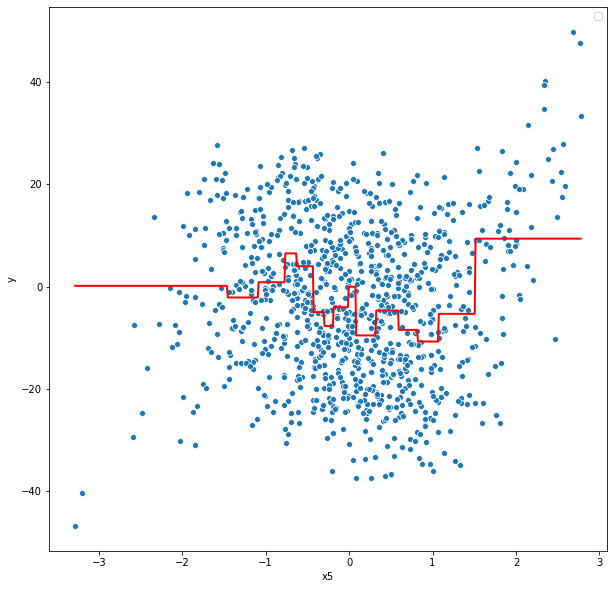

In [10]:
# Plot
X_mesh = np.arange(df9['x5'].min(), df9['x5'].max(), .01).reshape(-1, 1)  # reshape used to create an array for DereksRandomForest
y_mesh = rf1.predict(X=X_mesh)

plt.figure(figsize=(10, 10))
sb.scatterplot(data=df9, x='x5', y='y')
sb.lineplot(X_mesh[:, 0], y_mesh, color='red', linewidth=2)
plt.legend()
plt.show()

Eh, it picks up on pieces but overall not great.

Let's see how things change if we fit 2 trees.

In [11]:
# Initialize and fit
rf1_2 = DereksRandomForest(n_trees=2, n_features=1, X=X, y=y)
rf1_2.fit(
    max_depth=10,
    min_samples_leaf=50
)

In [12]:
# Inspect individual predictions
rf1_2.predict_individual_trees()[:5, :5]

array([[ -7.34996118,   0.83187993,  -4.26339442,   0.83187993,
         -9.12197784],
       [ -8.13358695,   3.4256464 ,  -2.78355935,  -6.25807035,
        -11.28369154]])

In [13]:
# Inspect overall predictions (should be the midpoint between the two individual predictions above!)
rf1_2.predict()[:5]

array([ -7.74177407,   2.12876316,  -3.52347689,  -2.71309521,
       -10.20283469])

No handles with labels found to put in legend.


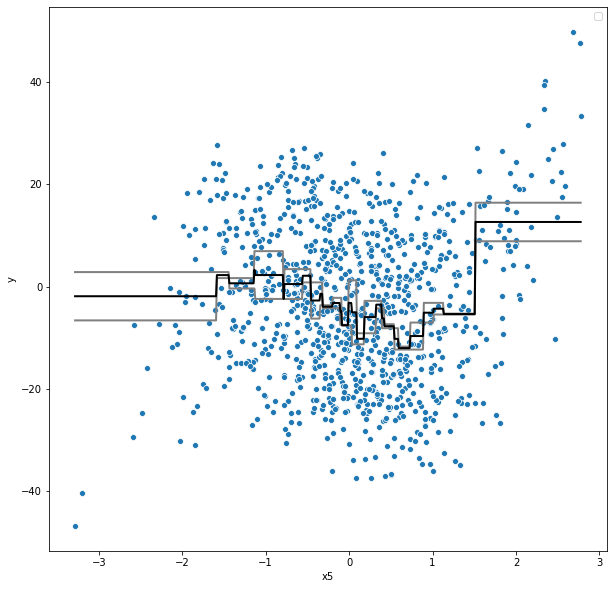

In [14]:
# Plot
X_mesh = np.arange(df9['x5'].min(), df9['x5'].max(), .01).reshape(-1, 1)
y_mesh_individual = rf1_2.predict_individual_trees(X=X_mesh)
y_mesh = rf1_2.predict(X=X_mesh)

plt.figure(figsize=(10, 10))
sb.scatterplot(data=df9, x='x5', y='y')
for i in y_mesh_individual:
    sb.lineplot(X_mesh[:, 0], i, color='grey', linewidth=2)
sb.lineplot(X_mesh[:, 0], y_mesh, color='black', linewidth=2)
plt.legend()
plt.show()

Overall it looks a bit smoother than each tree individually.  Let's try building 10 trees.

In [15]:
# Initialize and fit
rf1_3 = DereksRandomForest(n_trees=10, n_features=1, X=X, y=y)
rf1_3.fit(
    max_depth=10,
    min_samples_leaf=50
)

No handles with labels found to put in legend.


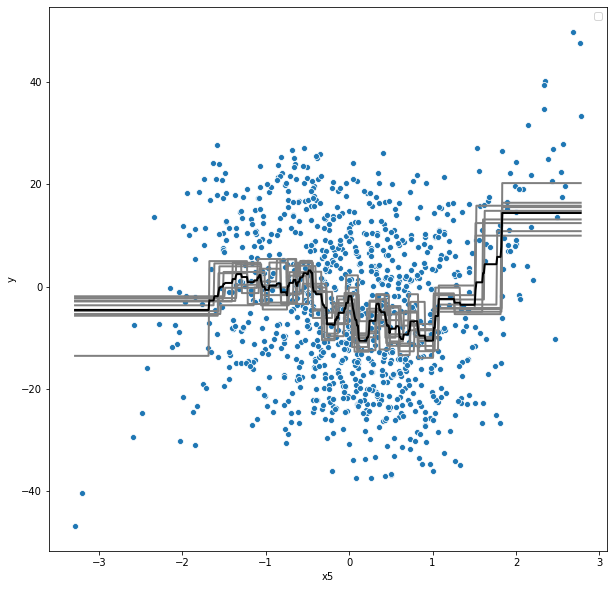

In [16]:
# Plot
X_mesh = np.arange(df9['x5'].min(), df9['x5'].max(), .01).reshape(-1, 1)
y_mesh_individual = rf1_3.predict_individual_trees(X=X_mesh)
y_mesh = rf1_3.predict(X=X_mesh)

plt.figure(figsize=(10, 10))
sb.scatterplot(data=df9, x='x5', y='y')
for i in y_mesh_individual:
    sb.lineplot(X_mesh[:, 0], i, color='grey', linewidth=2)
sb.lineplot(X_mesh[:, 0], y_mesh, color='black', linewidth=2)
plt.legend()
plt.show()

It's starting to look more like a real function!

Let's go crazy and build 100 subtrees.

In [17]:
# Initialize and fit
rf1_4 = DereksRandomForest(n_trees=100, n_features=1, X=X, y=y)
rf1_4.fit(
    max_depth=10,
    min_samples_leaf=50
)

No handles with labels found to put in legend.


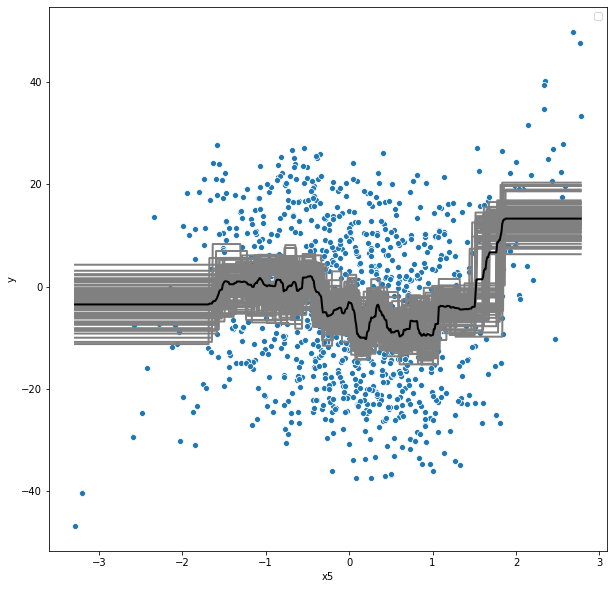

In [18]:
# Plot
X_mesh = np.arange(df9['x5'].min(), df9['x5'].max(), .01).reshape(-1, 1)
y_mesh_individual = rf1_4.predict_individual_trees(X=X_mesh)
y_mesh = rf1_4.predict(X=X_mesh)

plt.figure(figsize=(10, 10))
sb.scatterplot(data=df9, x='x5', y='y')
for i in y_mesh_individual:
    sb.lineplot(X_mesh[:, 0], i, color='grey', linewidth=2)
sb.lineplot(X_mesh[:, 0], y_mesh, color='black', linewidth=2)
plt.legend()
plt.show()

It looks we might still be having some variance problems, so let's try bumping up the min sample size to 100 and see how it looks.

In [19]:
# Initialize and fit
rf1_5 = DereksRandomForest(n_trees=100, n_features=1, X=X, y=y)
rf1_5.fit(
    max_depth=10,
    min_samples_leaf=100
)

No handles with labels found to put in legend.


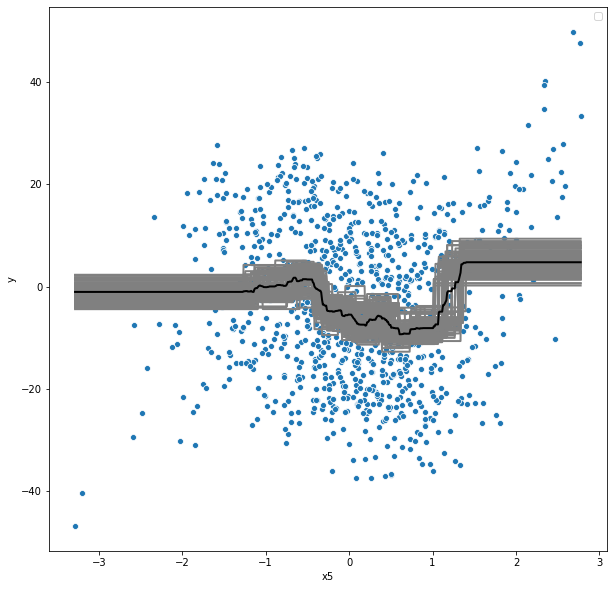

In [20]:
# Plot
X_mesh = np.arange(df9['x5'].min(), df9['x5'].max(), .01).reshape(-1, 1)
y_mesh_individual = rf1_5.predict_individual_trees(X=X_mesh)
y_mesh = rf1_5.predict(X=X_mesh)

plt.figure(figsize=(10, 10))
sb.scatterplot(data=df9, x='x5', y='y')
for i in y_mesh_individual:
    sb.lineplot(X_mesh[:, 0], i, color='grey', linewidth=2)
sb.lineplot(X_mesh[:, 0], y_mesh, color='black', linewidth=2)
plt.legend()
plt.show()

Definitely looks smoother!

### 2. Let's test feature subsetting by using 2 of 4 potential predictors:

- x1 (top hat)
- x5
- x7
- x9

With this implement, we'll ***technically*** pick 2 columns in the resulting data, which has 7 columns:

- 1 (x1) + 1 (x5) + 2 (x7 values) + 3 (x10 values)

In [21]:
# Get matrices
predictors = ['x1', 'x5', 'x7', 'x10']
X, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x10']).to_numpy(), df9['y']

# Inspect
print(X[:5])
print()
print(y[:5])

[[-1.91287732  0.47413699  0.          1.          0.          0.
   1.        ]
 [-0.34125209 -0.49252325  1.          0.          0.          1.
   0.        ]
 [ 0.65815696  0.3592403   1.          0.          0.          1.
   0.        ]
 [ 2.28853992 -0.43675977  0.          1.          0.          0.
   1.        ]
 [ 0.61835764  0.09820617  0.          1.          0.          0.
   1.        ]]

0   -23.858957
1     4.795576
2    16.359090
3   -24.550723
4   -23.033020
Name: y, dtype: float64


In [22]:
# Initialize and fit
rf2 = DereksRandomForest(n_trees=100, n_features=2, X=X, y=y)
rf2.fit(
    max_depth=10,
    min_samples_leaf=50
)

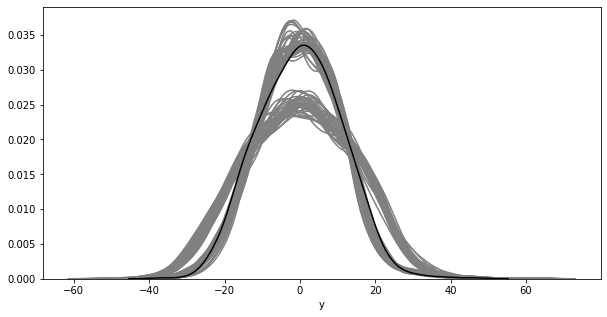

In [23]:
# Plot errors
plt.figure(figsize=(10, 5))
for i in rf2.predict_individual_trees():
    sb.distplot(y - i, hist=False, color='grey')
sb.distplot(y - rf2.predict(X), hist=False, color='black')

### 3. Let's fit everything (except x9) and see how it compares to a standard tree


Let's randomly select 5 predictors for each tree

In [24]:
# Get matrices
predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10']
X, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x8', 'x10']).to_numpy(), df9['y']

# Inspect
print(X[:5])
print()
print(y[:5])

[[-1.91287732 -0.50973817  1.93592263 -2.11999195  0.47413699  3.64754339
   0.          1.          0.          1.          0.          0.
   0.          0.          0.          1.        ]
 [-0.34125209  0.34150184  2.26866605 -0.94883455 -0.49252325  4.15911275
   1.          0.          0.          0.          0.          1.
   0.          0.          1.          0.        ]
 [ 0.65815696 -0.34793328  3.10440884  0.23692783  0.3592403   6.49855668
   1.          0.          0.          0.          0.          1.
   0.          0.          1.          0.        ]
 [ 2.28853992 -1.02883396  3.5544893  -0.2151365  -0.43675977  7.15487386
   0.          1.          1.          0.          0.          0.
   0.          0.          0.          1.        ]
 [ 0.61835764 -1.52687733  3.8571972  -0.34390204  0.09820617  7.85779367
   0.          1.          0.          1.          0.          0.
   0.          0.          0.          1.        ]]

0   -23.858957
1     4.795576
2    16.35909

In [25]:
# Initialize and fit
rf3 = DereksRandomForest(n_trees=100, n_features=5, X=X, y=y)
rf3.fit(
    max_depth=10,
    min_samples_leaf=50
)

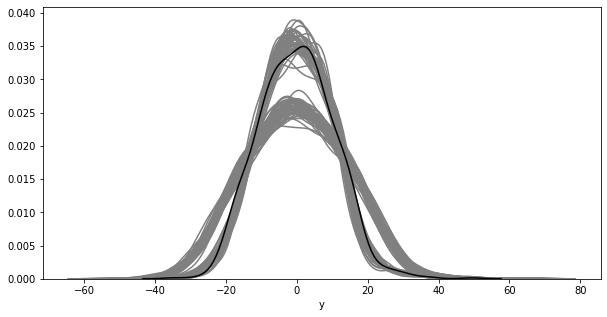

In [26]:
# Plot errors
plt.figure(figsize=(10, 5))
for i in rf3.predict_individual_trees():
    sb.distplot(y - i, hist=False, color='grey')
sb.distplot(y - rf3.predict(X), hist=False, color='black')

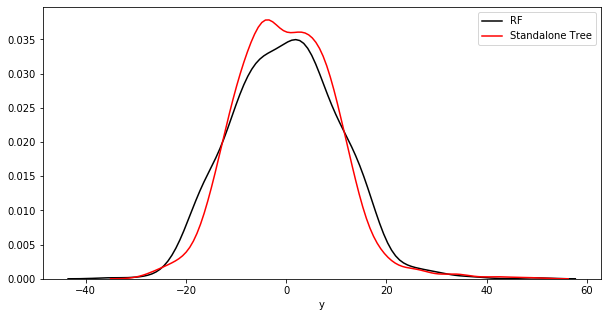

In [27]:
# Compare to a standalone tree with the same params
t3 = DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=50,
    random_state=666
).fit(X, y)

plt.figure(figsize=(10, 5))
sb.distplot(y - rf3.predict(X), hist=False, color='black', label='RF')
sb.distplot(y - t3.predict(X), hist=False, color='red', label='Standalone Tree')

At least on the training data, it looks like the Random Forest is performing a bit worse.  But without train/test/holdout, it's hard to say for certain.

Don't worry, we're almost there.

# Gradient Boosted Trees

Gradient Boosted Trees build sequential trees, where the next tree tries to improve where the previous tree did most poorly.  

- Build an initial tree
- Buld `n_trees - 1` additional trees, but predict the ***residual*** caused by the previous tree instead of the actual target
- "Predict" the sum of those tree augmented by a `learning_rate`, which tells the gradient boosted tree how fast to learn from additional trees that are built

The individual trees are usually very shallow (i.e. low depth).

For example, saw that we build two trees with a learning rate of 0.5.  The resulting predictions will be:

`T1 + 0.5 * T2`

Where:

- `T1` ~ Tree predicting the target `y` (sets "baseline" predictions)
- `T2` ~ Tree predicting `y - T1_pred`, where `T1_pred` is the prediction of `T1`

See https://en.wikipedia.org/wiki/Gradient_boosting#Gradient_tree_boosting for some details and links (e.g. to the original research paper).

In [28]:
# Create class
class DereksGBM(object):
    def __init__(self, n_trees, learning_rate, X, y):
        """
        n_trees: How many independent trees to build
        learning_rate: The learning rate constant
        X: The matrix of rows and predictors
        y: The targets
        """
        self.n_trees = n_trees
        self.learning_rate = learning_rate
        self.X = X
        self.y = y
        self.trees = []
        
    def fit(self, **kwargs):
        """Create n_trees trees, each with it's own bootstraped and feature-subsetted data set
        kwargs: Kwargs passed to DecisionTreeRegressor
        """
        for i in range(self.n_trees):
            # If the first tree, build as is
            # Else, build on residual from previous tree
            if i == 0:
                self.trees += [DecisionTreeRegressor(**kwargs).fit(self.X, self.y)]
            else:
                # Get residual from previous tree
                resid = self.y - self.predict(self.X, n=i)
                self.trees += [DecisionTreeRegressor(**kwargs).fit(self.X, resid)]
    
    def predict(self, X=None, n=None):
        """Return prediction, taking mean across all trees
        If no X provided, will use the input data
        n: number of trees to build out the predict for
        """
        if X is None:
            X = self.X
        if n is None:
            n = self.n_trees
        for i in range(n):
            if i == 0:
                pred = self.trees[i].predict(X)
            else:
                pred = pred + self.learning_rate * self.trees[i].predict(X)
        return pred

### 1. To illustrate, let's model using just x5 (i.e. no feature subsetting)

In [29]:
# Get matrices
X, y = df9[['x5']].to_numpy(), df9['y']

# Inspect
print(X[:5])
print()
print(y[:5])

[[ 0.47413699]
 [-0.49252325]
 [ 0.3592403 ]
 [-0.43675977]
 [ 0.09820617]]

0   -23.858957
1     4.795576
2    16.359090
3   -24.550723
4   -23.033020
Name: y, dtype: float64


In [30]:
# Initialize and fit
gb1 = DereksGBM(n_trees=1, learning_rate=0.3, X=X, y=y)
gb1.fit(
    max_depth=3,
    min_samples_leaf=50
)

In [31]:
# Inspect overall predictions
gb1.predict()[:5]

array([-6.92959819,  0.617181  , -6.92959819,  0.617181  , -6.92959819])

No handles with labels found to put in legend.


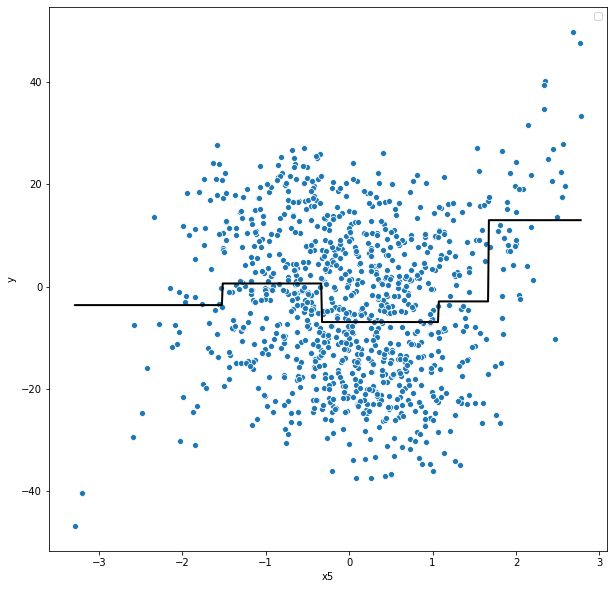

In [32]:
# Plot
X_mesh = np.arange(df9['x5'].min(), df9['x5'].max(), .01).reshape(-1, 1)  # reshape used to create an array for DereksRandomForest
y_mesh = gb1.predict(X=X_mesh)

plt.figure(figsize=(10, 10))
sb.scatterplot(data=df9, x='x5', y='y')
sb.lineplot(X_mesh[:, 0], y_mesh, color='black', linewidth=2)
plt.legend()
plt.show()

Directionally it seems to be doing the right thing, but overall not great.

Let's see how things change if we fit 2 trees.

In [33]:
# Initialize and fit
gb1_2 = DereksGBM(n_trees=2, learning_rate=0.3, X=X, y=y)
gb1_2.fit(
    max_depth=3,
    min_samples_leaf=50
)

No handles with labels found to put in legend.


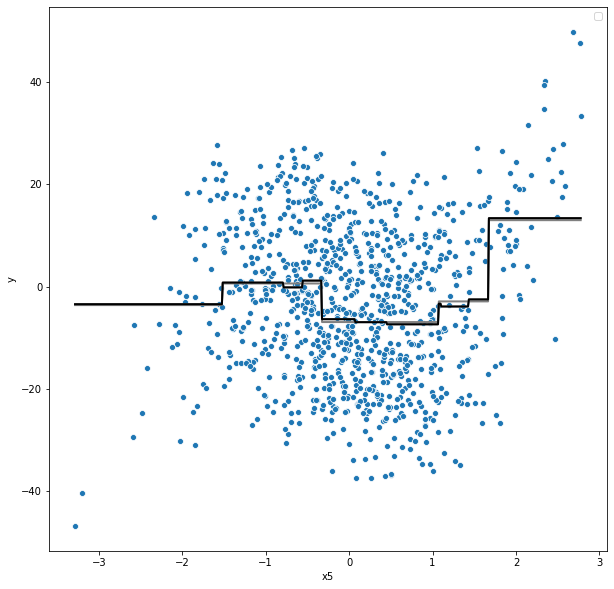

In [34]:
# Plot
X_mesh = np.arange(df9['x5'].min(), df9['x5'].max(), .01).reshape(-1, 1)  # reshape used to create an array for DereksRandomForest
y_mesh = gb1_2.predict(X=X_mesh)

plt.figure(figsize=(10, 10))
sb.scatterplot(data=df9, x='x5', y='y')
for i in range(gb1_2.n_trees):
    sb.lineplot(X_mesh[:, 0], gb1_2.predict(X=X_mesh, n=i+1), color='grey', linewidth=2)
sb.lineplot(X_mesh[:, 0], y_mesh, color='black', linewidth=2)
plt.legend()
plt.show()

Some minor tweaks of the first tree.

Let's ramp to 5 subtrees.

In [35]:
# Initialize and fit
gb1_3 = DereksGBM(n_trees=5, learning_rate=0.3, X=X, y=y)
gb1_3.fit(
    max_depth=3,
    min_samples_leaf=50
)

No handles with labels found to put in legend.


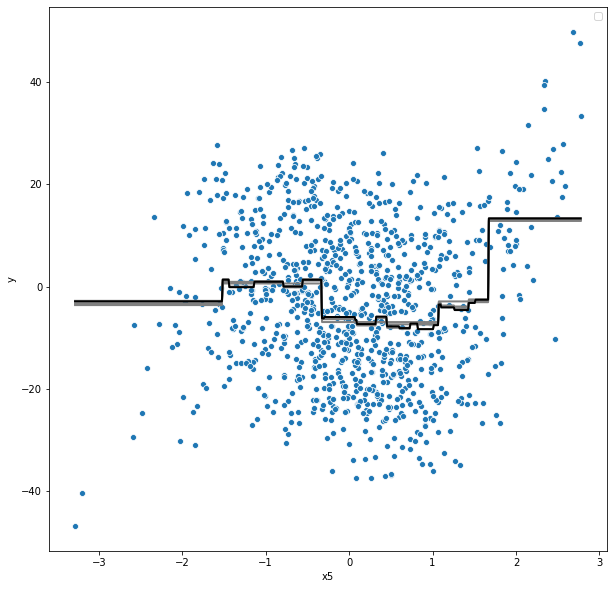

In [36]:
# Plot
X_mesh = np.arange(df9['x5'].min(), df9['x5'].max(), .01).reshape(-1, 1)  # reshape used to create an array for DereksRandomForest
y_mesh = gb1_3.predict(X=X_mesh)

plt.figure(figsize=(10, 10))
sb.scatterplot(data=df9, x='x5', y='y')
for i in range(gb1_3.n_trees):
    sb.lineplot(X_mesh[:, 0], gb1_3.predict(X=X_mesh, n=i+1), color='grey', linewidth=2)
sb.lineplot(X_mesh[:, 0], y_mesh, color='black', linewidth=2)
plt.legend()
plt.show()

Starting to look more like a cubic function!

Let's jump to 100 trees

In [37]:
# Initialize and fit
gb1_4 = DereksGBM(n_trees=100, learning_rate=0.3, X=X, y=y)
gb1_4.fit(
    max_depth=3,
    min_samples_leaf=50
)

No handles with labels found to put in legend.


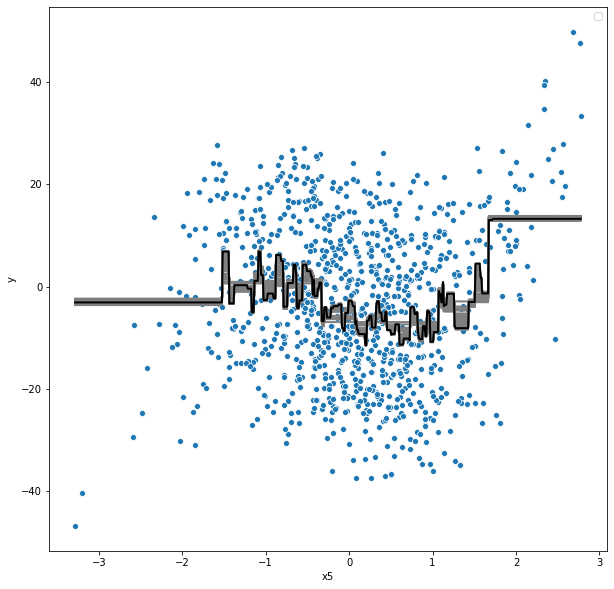

In [38]:
# Plot
X_mesh = np.arange(df9['x5'].min(), df9['x5'].max(), .01).reshape(-1, 1)  # reshape used to create an array for DereksRandomForest
y_mesh = gb1_4.predict(X=X_mesh)

plt.figure(figsize=(10, 10))
sb.scatterplot(data=df9, x='x5', y='y')
for i in range(gb1_4.n_trees):
    sb.lineplot(X_mesh[:, 0], gb1_4.predict(X=X_mesh, n=i+1), color='grey', linewidth=2)
sb.lineplot(X_mesh[:, 0], y_mesh, color='black', linewidth=2)
plt.legend()
plt.show()

Looks like we're starting to overfit now.

### 2. Let's fit everything (except x9) and see how it compares to a standard tree and our Random Forest predictor

In [39]:
# Get matrices
predictors = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10']
X, y = pd.get_dummies(df9[predictors], prefix=['x7', 'x8', 'x10']).to_numpy(), df9['y']

# Inspect
print(X[:5])
print()
print(y[:5])

[[-1.91287732 -0.50973817  1.93592263 -2.11999195  0.47413699  3.64754339
   0.          1.          0.          1.          0.          0.
   0.          0.          0.          1.        ]
 [-0.34125209  0.34150184  2.26866605 -0.94883455 -0.49252325  4.15911275
   1.          0.          0.          0.          0.          1.
   0.          0.          1.          0.        ]
 [ 0.65815696 -0.34793328  3.10440884  0.23692783  0.3592403   6.49855668
   1.          0.          0.          0.          0.          1.
   0.          0.          1.          0.        ]
 [ 2.28853992 -1.02883396  3.5544893  -0.2151365  -0.43675977  7.15487386
   0.          1.          1.          0.          0.          0.
   0.          0.          0.          1.        ]
 [ 0.61835764 -1.52687733  3.8571972  -0.34390204  0.09820617  7.85779367
   0.          1.          0.          1.          0.          0.
   0.          0.          0.          1.        ]]

0   -23.858957
1     4.795576
2    16.35909

In [40]:
# Initialize and fit
gb2 = DereksGBM(n_trees=100, learning_rate=0.3, X=X, y=y)
gb2.fit(
    max_depth=3,
    min_samples_leaf=50
)

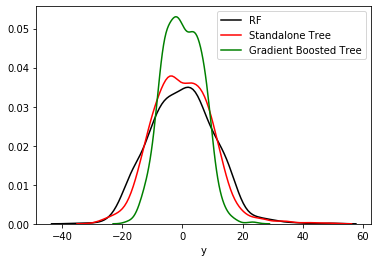

In [41]:
# Compare to a standalone tree and Random Forest
sb.distplot(y - rf3.predict(X), hist=False, color='black', label='RF')
sb.distplot(y - t3.predict(X), hist=False, color='red', label='Standalone Tree')
sb.distplot(y - gb2.predict(X), hist=False, color='green', label='Gradient Boosted Tree')

The GBM looks noticably better than the other two.  But, alas, we can't say anything definitive yet with train/test/holdout.